In [1]:
# https://keras.io/
!pip install -q keras
!pip install scikit-image

### Confirm TensorFlow can see the GPU

In [2]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [3]:
# Load data
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


In [0]:
def single_layer_autoencoder(x_train, x_test, init_image_dim=784, encoding_dim=32):
  """
  params:
  > encoding_dim: this is the size of our encoded representations
  """
  input_img = Input(shape=(init_image_dim,))
  encoded = Dense(encoding_dim, activation='relu')(input_img)  # the encoded representation of the input
  decoded = Dense(init_image_dim, activation='sigmoid')(encoded)  # the lossy reconstruction of the input

  autoencoder = Model(input_img, decoded)  # this model maps an input to its reconstruction
  encoder = Model(input_img, encoded)  # this model maps an input to its encoded representation
  encoded_input = Input(shape=(encoding_dim,))  # create a placeholder for an encoded (32-dimensional) input
  decoder_layer = autoencoder.layers[-1]  # retrieve the last layer of the autoencoder model

  decoder = Model(encoded_input, decoder_layer(encoded_input))  # create the decoder model

  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

  autoencoder.fit(x_train, x_train,
                  epochs=50,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))
  
  # encode and decode some digits
  # note that we take them from the *test* set
  encoded_imgs = encoder.predict(x_test)
  decoded_imgs = decoder.predict(encoded_imgs)
  return encoded_imgs, decoded_imgs

In [0]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

def draw_decoded_images(x_test, decoded_imgs, n=12):
  """
  params:
  > n: how many digits we will display
  """
  plt.figure(figsize=(20, 4))
  for i in range(n):
      # display original
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstruction
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_imgs[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

In [7]:
encoded_imgs, decoded_imgs = single_layer_autoencoder(x_train, x_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
59392/60000 [============================>.] - ETA: 0s - loss: 0.3543

KeyboardInterrupt: ignored

In [8]:
draw_decoded_images(x_test, decoded_imgs)

NameError: ignored

In [0]:
def single_layer_autoencoder_with_sparsity_constraint(x_train, x_test, init_image_dim=784, encoding_dim=32, epochs=100):
  """
  params:
  > encoding_dim: this is the size of our encoded representations
  """
  from keras.models import Sequential
  from keras.layers import Dense
  from keras import regularizers
  
  encoded1 = Dense(encoding_dim, activity_regularizer=regularizers.l2(10e-6), 
                   activation='relu', input_shape=(init_image_dim,))
  decoded1 = Dense(init_image_dim, activation='sigmoid', input_shape=(encoding_dim,))
  
  autoencoder = Sequential([encoded1, decoded1])
  encoder = Sequential([encoded1])
  decoder = Sequential([decoded1])
  
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

  autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))
  
  # encode and decode some digits
  # note that we take them from the *test* set
  encoded_imgs = encoder.predict(x_test)
  decoded_imgs = decoder.predict(encoded_imgs)
  return encoded_imgs, decoded_imgs

In [62]:
encoded_imgs_2, decoded_imgs_2 = single_layer_autoencoder_with_sparsity_constraint(x_train, x_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.5926 - val_loss: 0.4507
Epoch 2/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.4031 - val_loss: 0.3747
Epoch 3/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.3589 - val_loss: 0.3480
Epoch 4/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.3388 - val_loss: 0.3330
Epoch 5/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.3265 - val_loss: 0.3229
Epoch 6/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.3181 - val_loss: 0.3159
Epoch 7/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.3119 - val_loss: 0.3101
Epoch 8/100
17408/60000 [=======>......................] - ETA: 1s - loss: 0.308960000/60000 [==============================] - 2s 26us/step - loss: 0.3069 - val_loss: 0.3055
Epoch 9/100
60000/60000 [========

59648/60000 [============================>.] - ETA: 0s - loss: 0.216460000/60000 [==============================] - 2s 26us/step - loss: 0.2164 - val_loss: 0.2159
Epoch 73/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.2159 - val_loss: 0.2154
Epoch 74/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.2154 - val_loss: 0.2149
Epoch 75/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.2150 - val_loss: 0.2144
Epoch 76/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.2145 - val_loss: 0.2138
Epoch 77/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.2140 - val_loss: 0.2136
Epoch 78/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.2136 - val_loss: 0.2130
Epoch 79/100
60000/60000 [==============================] - 2s 25us/step - loss: 0.2131 - val_loss: 0.2125
Epoch 80/100
  256/60000 [..............................] - ETA: 2s - loss: 0.215960000/

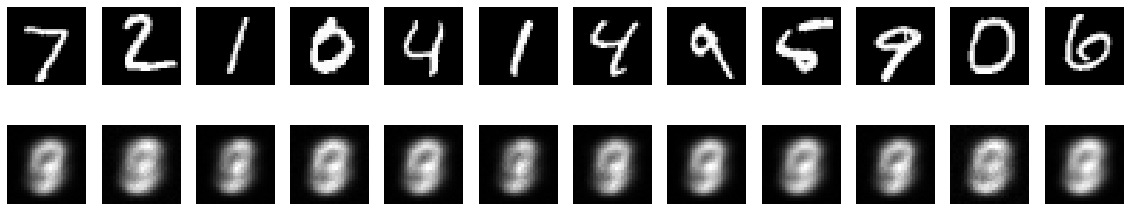

In [60]:
draw_decoded_images(x_test, decoded_imgs_2)

In [1]:
def deep_layer_autoencoder(x_train, x_test, init_image_dim=784, encoding_dim=32, epochs=100):
  """
  params:
  > encoding_dim: this is the size of our encoded representations
  """
  from keras.models import Sequential
  from keras.layers import Dense
  
  encoded1 = Dense(128, activation='relu', input_shape=(init_image_dim,))
  encoded2 = Dense(64, activation='relu')
  encoded3 = Dense(encoding_dim, activation='relu')
  
  decoded1 = Dense(64, activation='relu', input_shape=(encoding_dim,))
  decoded2 = Dense(128, activation='relu')
  decoded3 = Dense(init_image_dim, activation='sigmoid')
  
  autoencoder = Sequential([encoded1, encoded2, encoded3, decoded1, decoded2, decoded3])
  encoder = Sequential([encoded1, encoded2, encoded3])
  decoder = Sequential([decoded1, decoded2, decoded3])
  
  autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
  
  autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(x_test, x_test))
  
  # encode and decode some digits
  # note that we take them from the *test* set
  encoded_imgs = encoder.predict(x_test)
  decoded_imgs = decoder.predict(encoded_imgs)
  return encoded_imgs, decoded_imgs

In [2]:
encoded_imgs_3, decoded_imgs_3 = deep_layer_autoencoder(x_train, x_test)

NameError: name 'x_train' is not defined

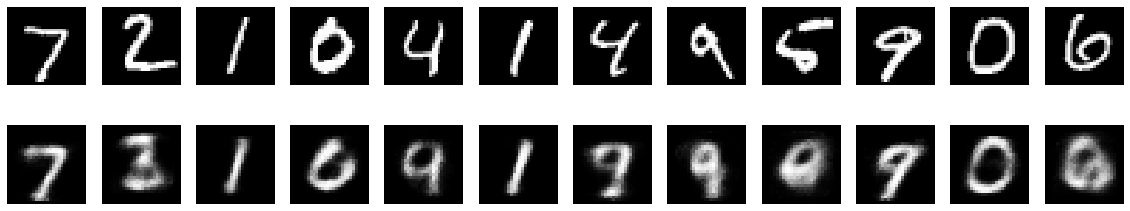

In [51]:
draw_decoded_images(x_test, decoded_imgs_3)

In [0]:
def cnn_autoencoder(x_train, x_test, init_image_dim=(28, 28, 1), encoding_dim=(4, 4, 8), epochs=50):
    from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
    from keras.models import Sequential
    from keras import backend as K

    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=init_image_dim)
    maxp1 = MaxPooling2D((2, 2), padding='same')
    conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')
    maxp2 = MaxPooling2D((2, 2), padding='same')
    conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')
    encoded = MaxPooling2D((2, 2), padding='same')

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=encoding_dim)
    upsa1 = UpSampling2D((2, 2))
    conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')
    upsa2 = UpSampling2D((2, 2))
    conv6 = Conv2D(16, (3, 3), activation='relu')
    upsa3 = UpSampling2D((2, 2))
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    autoencoder = Sequential([conv1, maxp1, conv2, maxp2, conv3, encoded,
                            conv4, upsa1, conv5, upsa2, conv6, upsa3, decoded])
    encoder = Sequential([conv1, maxp1, conv2, maxp2, conv3, encoded])
    decoder = Sequential([conv4, upsa1, conv5, upsa2, conv6, upsa3, decoded])

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train, x_train,
                  epochs=epochs,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test, x_test))

    # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    return encoded_imgs, decoded_imgs
  

In [71]:
x_train_cnn = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test_cnn = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

encoded_imgs_4, decoded_imgs_4 = cnn_autoencoder(x_train_cnn, x_test_cnn)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 9s 151us/step - loss: 0.2126 - val_loss: 0.1654
Epoch 2/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.1534 - val_loss: 0.1419
Epoch 3/5
60000/60000 [==============================] - 8s 134us/step - loss: 0.1388 - val_loss: 0.1343
Epoch 4/5
 7040/60000 [==>...........................] - ETA: 6s - loss: 0.133760000/60000 [==============================] - 8s 133us/step - loss: 0.1311 - val_loss: 0.1300
Epoch 5/5
60000/60000 [==============================] - 8s 134us/step - loss: 0.1260 - val_loss: 0.1242


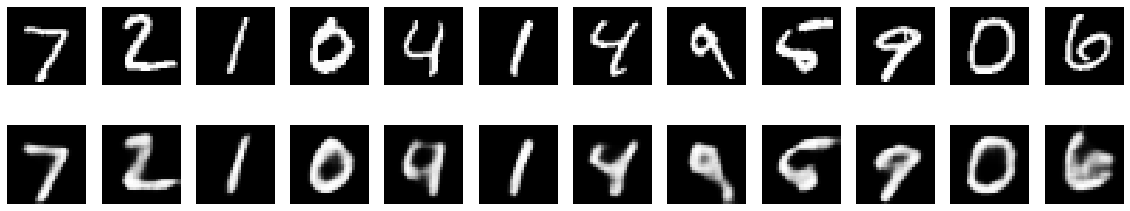

In [72]:
draw_decoded_images(x_test, decoded_imgs_4)

In [0]:
def visualise_encoded_cnn(encoded_imgs, n=12):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

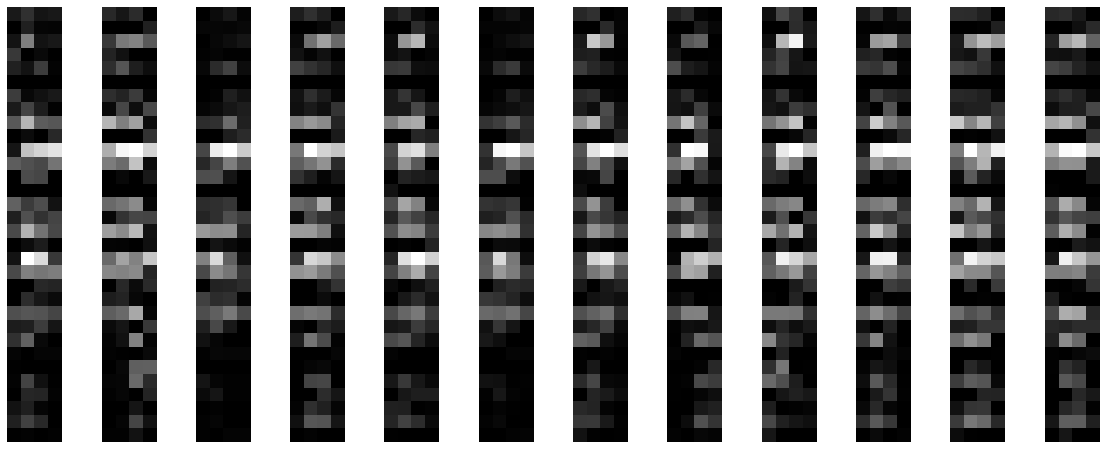

In [82]:
visualise_encoded_cnn(encoded_imgs_4)

In [0]:
def cnn_denoising_model(x_train, x_test, x_train_noisy, x_test_noisy, init_image_dim=(28, 28, 1), encoding_dim=(7, 7, 32), epochs=50):
    from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
    from keras.models import Sequential
    from keras import backend as K

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=init_image_dim)
    maxp1 = MaxPooling2D((2, 2), padding='same')
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
    encoded = MaxPooling2D((2, 2), padding='same')

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=encoding_dim)
    upsa1 = UpSampling2D((2, 2))
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')
    upsa2 = UpSampling2D((2, 2))
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    autoencoder = Sequential([conv1, maxp1, conv2, encoded,
                            conv3, upsa1, conv4, upsa2, decoded])
    encoder = Sequential([conv1, maxp1, conv2, encoded])
    decoder = Sequential([conv3, upsa1, conv4, upsa2, decoded])

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    autoencoder.fit(x_train_noisy, x_train,
                  epochs=epochs,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test_noisy, x_test))

    # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    return encoded_imgs, decoded_imgs

In [155]:
noise_factor = 0.5
x_train_cnn_noisy = x_train_cnn + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_cnn.shape)
x_test_cnn_noisy = x_test_cnn + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_cnn.shape)
x_train_cnn_noisy = np.clip(x_train_cnn_noisy, 0., 1.)
x_test_cnn_noisy = np.clip(x_test_cnn_noisy, 0., 1.)

encoded_imgs_5, decoded_imgs_5 = cnn_denoising_model(x_train_cnn, x_test_cnn, x_train_cnn_noisy, x_test_cnn_noisy, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
12032/60000 [=====>........................] - ETA: 12s - loss: 0.3569

KeyboardInterrupt: ignored

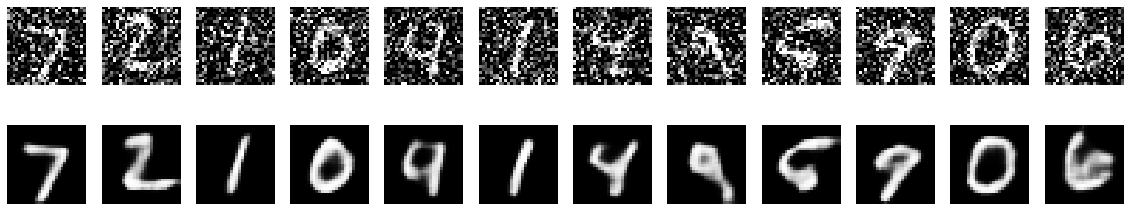

In [98]:
draw_decoded_images(x_test_cnn_noisy, decoded_imgs_4)

In [140]:
from skimage.transform import resize
x_train_downscaled = [resize(i, (14, 14), order=1, preserve_range=True) for i in x_train_cnn]
x_test_downscaled = [resize(i, (14, 14), order=1, preserve_range=True) for i in x_test_cnn]
print(np.shape(x_train_downscaled))
print(np.shape(x_test_downscaled))
x_train_upscaled = [resize(i, (28, 28), order=1, preserve_range=True) for i in x_train_downscaled]
x_test_upscaled = [resize(i, (28, 28), order=1, preserve_range=True) for i in x_test_downscaled]
print(np.shape(x_train_upscaled))
print(np.shape(x_test_upscaled))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(60000, 14, 14, 1)
(10000, 14, 14, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
x_train_upscaled = np.clip(x_train_upscaled, 0., 1.)
x_test_upscaled = np.clip(x_test_upscaled, 0., 1.)
x_train_downscaled = np.clip(x_train_downscaled, 0., 1.)
x_test_downscaled = np.clip(x_test_downscaled, 0., 1.)

In [159]:
encoded_imgs_6, decoded_imgs_6 = cnn_denoising_model(x_train_cnn, x_test_cnn, x_train_upscaled, x_test_upscaled, epochs=10)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 181us/step - loss: 0.1405 - val_loss: 0.0955
Epoch 2/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.0908 - val_loss: 0.0839
Epoch 3/10
46592/60000 [======================>.......] - ETA: 2s - loss: 0.084660000/60000 [==============================] - 10s 160us/step - loss: 0.0842 - val_loss: 0.0799
Epoch 4/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0810 - val_loss: 0.0793
Epoch 5/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0790 - val_loss: 0.0782
Epoch 6/10
24704/60000 [===========>..................] - ETA: 5s - loss: 0.078160000/60000 [==============================] - 10s 159us/step - loss: 0.0776 - val_loss: 0.0757
Epoch 7/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0765 - val_loss: 0.0741
Epoch 8/10
60000/60000 [==============================] - 9s 158u

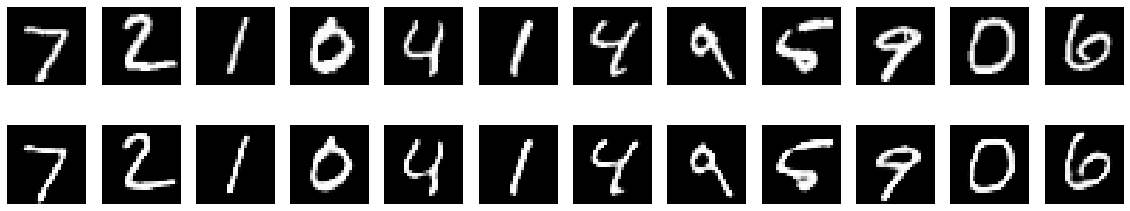

In [162]:
draw_decoded_images(x_test_upscaled, decoded_imgs_6)
# Original vs Upscaled

In [0]:
def cnn_upscaler(x_train, x_test, x_train_downscaled, x_test_downscaled, input_image_dim=(14, 14, 1), output_image_dim=(28, 28, 1), epochs=50):
  from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
  from keras.models import Sequential
  from keras import backend as K
  
  conv1 = Conv2D(14, (3, 3), activation='relu', padding='same', input_shape=input_image_dim)
  upsa1 = UpSampling2D((2, 2))
  upscaled = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

  upscaler = Sequential([conv1, upsa1, upscaled])
  
  upscaler.compile(optimizer='adadelta', loss='binary_crossentropy')
  
  upscaler.fit(x_train_downscaled, x_train,
                  epochs=epochs,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(x_test_downscaled, x_test))
  
  upscaled_images = upscaler.predict(x_test_downscaled)
  return upscaled_images

In [168]:
upscaled_images = cnn_upscaler(x_train_cnn, x_test_cnn, x_train_downscaled, x_test_downscaled)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 109us/step - loss: 0.1289 - val_loss: 0.0756
Epoch 2/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0741 - val_loss: 0.0721
Epoch 3/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0722 - val_loss: 0.0711
Epoch 4/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0716 - val_loss: 0.0706
Epoch 5/50
 6016/60000 [==>...........................] - ETA: 4s - loss: 0.071360000/60000 [==============================] - 5s 78us/step - loss: 0.0712 - val_loss: 0.0703
Epoch 6/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0709 - val_loss: 0.0701
Epoch 7/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0707 - val_loss: 0.0699
Epoch 8/50
60000/60000 [==============================] - 5s 78us/step - loss: 0.0705 - val_loss: 0.0697
Epoch 9/50
38400/60000 [================

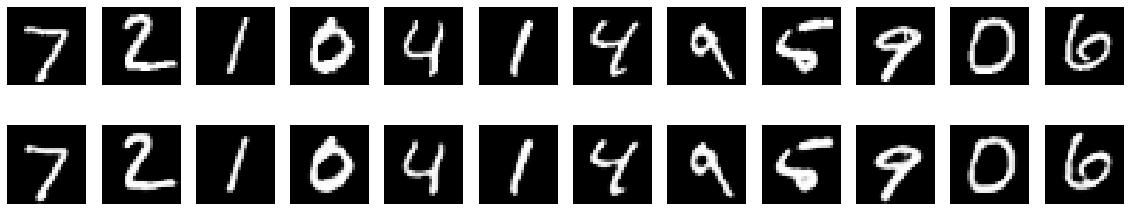

In [169]:
draw_decoded_images(x_test_cnn, upscaled_images)